In [12]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import re
from sklearn.preprocessing import RobustScaler
import scipy.stats as ss
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import scipy.io
from __future__ import division
from __future__ import print_function
import os
import sys
from time import time
import scipy.stats as ss
from sklearn.preprocessing import RobustScaler

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager
# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP # ensemble


from IPython.display import display

In [2]:
# dataset path
data_path = "/Users/kadima/experiment_any/anomaly-detection/datasets/"

# load data

In [3]:
def getData(fileName):
    # check fileName:
    files = [x for x in os.listdir(data_path) if x.endswith(".mat")]
    mat = scipy.io.loadmat(data_path+fileName)
    X = mat["X"]
    y = mat["y"]
    return X, y

def read_data_parkinson():
    file_path = "/Users/kadima/experiment_any/anomaly-detection/Parkinson_withoutdupl_75.txt"
    with open(file_path,'r') as f:
        data = f.readlines()
    # print(data[28:-2])
    col_names = []
    list_ = []
    for id_, line in enumerate(data):
        if line.startswith("@ATTRIBUTE"):
            colName = re.findall("@ATTRIBUTE '(.*?)'", line)[0]
            col_names.append(colName)
        if id_ >= 28 and id_<= len(data) - 1 and line != "\n":
            new_line = line.split(",")
            new_line = [x.strip() for x in new_line]
            new_line = [float(new_line[x]) for x in range(len(new_line)-1)] + \
                       [new_line[-1].replace("'", "")]
            list_.append(new_line)

    df = pd.DataFrame(list_, columns=col_names)
    df['outlier'] = df.outlier.apply(lambda x: 1 if x =='yes' else 0)
    X = df.iloc[:, 1:-1]
    y = df.iloc[:, -1]
    return X, y




# thresholders

In [48]:
def sd_thresholder(scores, real_y, factor=2.5):
    high_limit = np.mean(scores) + factor*np.std(scores)
    y_predict = scores>=high_limit
    y_predict = [1 if j else 0 for j in y_predict]
    f1 = f1_score(real_y, y_predict)
    return y_predict, f1, high_limit


def mad_thresholder(scores, real_y):
    median_ = np.median(scores)
    mad = 1.4826*np.median(np.abs(scores-median_))
    y_predict = scores>= 3*mad
    y_predict = [1 if j else 0 for j in y_predict]
    f1 = f1_score(real_y, y_predict)
    return y_predict, f1, 3*mad


def iqr_thresholder(scores, real_y):
    iqr = np.percentile(scores,75) - np.percentile(scores,25)
    y_predict = scores >= (np.percentile(scores,75)+1.5*iqr)
    y_predict = [1 if j else 0 for j in y_predict]
    f1 = f1_score(real_y, y_predict)
    return y_predict, f1, np.percentile(scores,75)+1.5*iqr


def disagreement_v1(score_matrix, num_detectors, real_y):
    rank_matrix = np.zeros([len(score_matrix), num_detectors])
    for i in range(num_detectors):
    # rank by each column and get its rank_position
        rank_matrix[:,i] = ss.rankdata(score_matrix[:, i])
    std_record = np.zeros(len(X))
    rank_record = []
    for i in range(len(score_matrix)):
        rank_rows = rank_matrix[i,:]
        min_ = np.min(rank_rows)
        max_ = np.max(rank_rows)
        rank_rows  = [x for x in rank_rows if x not in [min_,max_]]
        std_record[i] = np.std(rank_rows)
        rank_record.append(rank_rows)
    valid_rank_rows = []
    for i in range(len(score_matrix)):
        num_large = np.sum(np.array(rank_record[i]) >= len(score_matrix)//3)
        if num_large >= num_detectors//3:
            valid_rank_rows.append(i)
    std_max_rows = np.argsort(np.array(std_record)[valid_rank_rows])[-1:]
    std_median_scores = np.median(score_matrix[std_max_rows,:], axis=0)
    threshold_for_each_detector = std_median_scores
    
    f1_list = []
    for i in range(num_detectors):
        outliers_rows = score_matrix[:,i] >= threshold_for_each_detector[i]
        y_predict = [1 if j else 0 for j in outliers_rows]
        f1 = f1_score(real_y, y_predict)
        f1_list.append(f1)
    return f1_list, threshold_for_each_detector, std_record

def disagreement_v2(score_matrix, num_detectors, real_y, remove_extreme = False):
    # normalize the score_matrix
    origin_score_matrix = score_matrix.copy()
    score_matrix = RobustScaler().fit_transform(score_matrix)
    
    # get rank matrix
    rank_matrix = np.zeros([len(score_matrix), num_detectors])
    for i in range(num_detectors):
    # rank by each column and get its rank_position
        rank_matrix[:,i] = ss.rankdata(score_matrix[:, i],'ordinal')
    std_record = np.zeros(len(score_matrix))

    # form a matrix for each row
    for row_idx in range(len(score_matrix)):
        tmp_matrix = np.zeros([num_detectors, num_detectors])
        for col_idx in range(num_detectors):
            rank_refer = rank_matrix[row_idx, col_idx]
            for col_idx_2 in range(num_detectors):
                if col_idx_2 == col_idx:
                    tmp_matrix[col_idx, col_idx_2] = 0
                else:
                    target_row = np.argwhere(rank_matrix[:,col_idx_2] == rank_refer)
                    target_row = target_row[0][0]
                    curr_score = score_matrix[row_idx, col_idx_2]
                    refer_score = score_matrix[target_row, col_idx_2]
                    tmp_matrix[col_idx, col_idx_2] = curr_score - refer_score
                    
        if remove_extreme:
            tmp_matrix_row_std = np.std(tmp_matrix, axis=1)
            tmp_matrix_col_std = np.std(tmp_matrix, axis=0)
            max_std_row = np.argmax(tmp_matrix_row_std)
            max_std_col = np.argmax(tmp_matrix_col_std)
            # skip the max one
            robust_tmp_matrix = tmp_matrix[[i_ for i_ in range(num_detectors) if i_!=max_std_row],:]
            robust_tmp_matrix = robust_tmp_matrix[:,[i_ for i_ in range(num_detectors) if i_!=max_std_col]]
            
            
        else:
            robust_tmp_matrix = tmp_matrix
        std_record[row_idx] = np.mean(abs(robust_tmp_matrix))

    std_max_row = np.argmax(std_record)
    threshold_for_each_detector = score_matrix[std_max_row,:]
    origin_threshold = origin_score_matrix[std_max_row, :]
    f1_list = []
    
    for i in range(num_detectors):
        outliers_rows = score_matrix[:,i] >= threshold_for_each_detector[i]
        y_predict = [1 if j else 0 for j in outliers_rows]
        f1 = f1_score(real_y, y_predict)
        f1_list.append(f1)
        
    return f1_list, origin_threshold, std_record


def disagreement_v3(score_matrix, num_detectors, real_y, remove_extreme = False):
    # normalize the score_matrix
    score_matrix = RobustScaler().fit_transform(score_matrix)
    
    # get rank matrix
    rank_matrix = np.zeros([len(score_matrix), num_detectors])
    for i in range(num_detectors):
    # rank by each column and get its rank_position
        rank_matrix[:,i] = ss.rankdata(score_matrix[:, i],'ordinal')
    std_record = np.zeros((len(score_matrix), num_detectors))

    # form a matrix for each row
    for row_idx in range(len(score_matrix)):
        tmp_matrix = np.zeros([num_detectors, num_detectors])
        for col_idx in range(num_detectors):
            rank_refer = rank_matrix[row_idx, col_idx]
            col_increment = 0
            for col_idx_2 in range(num_detectors):
                target_row = np.argwhere(rank_matrix[:,col_idx_2] == rank_refer)
                target_row = target_row[0][0]
                curr_score = score_matrix[row_idx, col_idx_2]
                refer_score = score_matrix[target_row, col_idx_2]
                tmp_matrix[col_idx, col_increment] = curr_score - refer_score
                col_increment += 1
                    
        if remove_extreme:
            tmp_matrix_row_std = np.std(tmp_matrix, axis=1)
            tmp_matrix_col_std = np.std(tmp_matrix, axis=0)
            max_std_row = np.argmax(tmp_matrix_row_std)
            max_std_col = np.argmax(tmp_matrix_col_std)
            # skip the max one
            robust_tmp_matrix = tmp_matrix[[i_ for i_ in range(num_detectors) if i_!=max_std_row],:]
            robust_tmp_matrix = robust_tmp_matrix[:,[i_ for i_ in range(num_detectors) if i_!=max_std_col]]

            
            
        else:
            robust_tmp_matrix = tmp_matrix
            
        detector_disagreement = []
        for j_ in range(num_detectors):
            std_record[row_idx, j_] = np.mean(np.abs(np.concatenate((robust_tmp_matrix[j_,:], 
                                                              robust_tmp_matrix[:,j_]),
                                                             axis=None)))
            

    std_max_row = np.argmax(std_record, axis = 0)
    threshold_for_each_detector = score_matrix[std_max_row, np.arange(num_detectors)]
    f1_list = []
    
    for i in range(num_detectors):
        outliers_rows = score_matrix[:,i] >= threshold_for_each_detector[i]
        y_predict = [1 if j else 0 for j in outliers_rows]
        f1 = f1_score(real_y, y_predict)
        f1_list.append(f1)
        
    return f1_list, threshold_for_each_detector, std_record


In [5]:
def get_score_matrix(X, num_detectors):
    return np.zeros([X.shape[0], num_detectors])

def get_perform_matrix(num_thresholders, num_detectors):
    return np.zeros((num_thresholders, num_detectors))


# Detectors

In [47]:
random_state = np.random.RandomState(10)
outliers_fraction = 0.4
# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state, n_estimators = 280),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state)
}

names = []
# Show all detectors
for i, clf in enumerate(classifiers.keys()):
    names.append(clf)
#     print('Model', i + 1, clf)

In [ ]:
X,y = read_data_parkinson()

In [20]:
# Fit the models with the generated data and 
# compare model performances
def get_result(X, y, classifiers):
    threshold_records = list()
    # create matrix to store the performance
    score_matrix = get_score_matrix(X, len(classifiers.keys()))
    perform_table = get_perform_matrix(5, len(classifiers.keys()) )

    np.random.seed(5)
    clfs = []
    # Fit the model
    for i, (clf_name, clf) in enumerate(classifiers.items()):
#         print(i + 1, 'fitting', clf_name)
        # fit the data and tag outliers
        clf.fit(X)
        clfs.append(clf)
        scores_pred = clf.decision_function(X)
        score_matrix[:, i] = scores_pred
        

    for i, thresholder in enumerate([sd_thresholder, mad_thresholder, 
                                     iqr_thresholder]):
        kk = []
        for j in range(score_matrix.shape[1]):
            _,perform_table[i,j],b = thresholder(score_matrix[:,j], y)
            kk.append(b)
            
        threshold_records.append(kk)
            
    for i in range(score_matrix.shape[1]):
        perform_table[-2,i] = f1_score(y,clfs[i].predict(X))
        
    perform_table[-1,:], a, dist_ = disagreement_v2(score_matrix, len(classifiers), y,True)
    threshold_records.append(a)
    
    return (pd.DataFrame(perform_table, columns = names, index = ["sd",'mad','iqr','default','disagreement']), 
            threshold_records, dist_, score_matrix)

In [ ]:
df, records, disagree_score, score_matrtix = get_result(X, y, classifiers)
records = pd.DataFrame([np.array(x) for x in records])

In [ ]:
y_color = y.apply(lambda x: 'red' if x==1 else 'green')

In [ ]:
df

In [ ]:
disagree_score.shape

In [ ]:
fig, ax = plt.subplots(12, 1, figsize=(10,20))

for i in range(12):
    ax[i].scatter(score_matrtix[:,i], disagree_score[:,i], c = y_color)
    ax[i].title.set_text(names[i] + str(round(df.iloc[4,i],3)) + "  "+ str(round(df.iloc[3,i],3)))
plt.tight_layout()
plt.show()

In [ ]:
df

In [ ]:
df.apply(lambda x: np.mean(x), axis=1)

In [21]:
for datasets in os.listdir("/Users/kadima/experiment_any/anomaly-detection/datasets/"):
    print(datasets)

pima.mat
cardio.mat
letter.mat
musk.mat
thyroid.mat
vowels.mat
satellite.mat
lympho.mat
speech.mat
wbc.mat
glass.mat
satimage-2.mat


In [49]:
result_dict = dict()
bug_datasets = ["letter.mat","speech.mat","cardio.mat"]
for datasets in os.listdir("/Users/kadima/experiment_any/anomaly-detection/datasets/"):
    if datasets in bug_datasets:
        continue
    print(datasets)
    X,y = getData(datasets)
    X = X.astype(np.float64)
    result_dict[datasets] = get_result(X, y, classifiers)
    print("\n\n")

pima.mat


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"





musk.mat


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"





thyroid.mat


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.8/site-packages




vowels.mat


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"





satellite.mat


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"





lympho.mat


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"





wbc.mat


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"





glass.mat


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"





satimage-2.mat


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


# Lympho

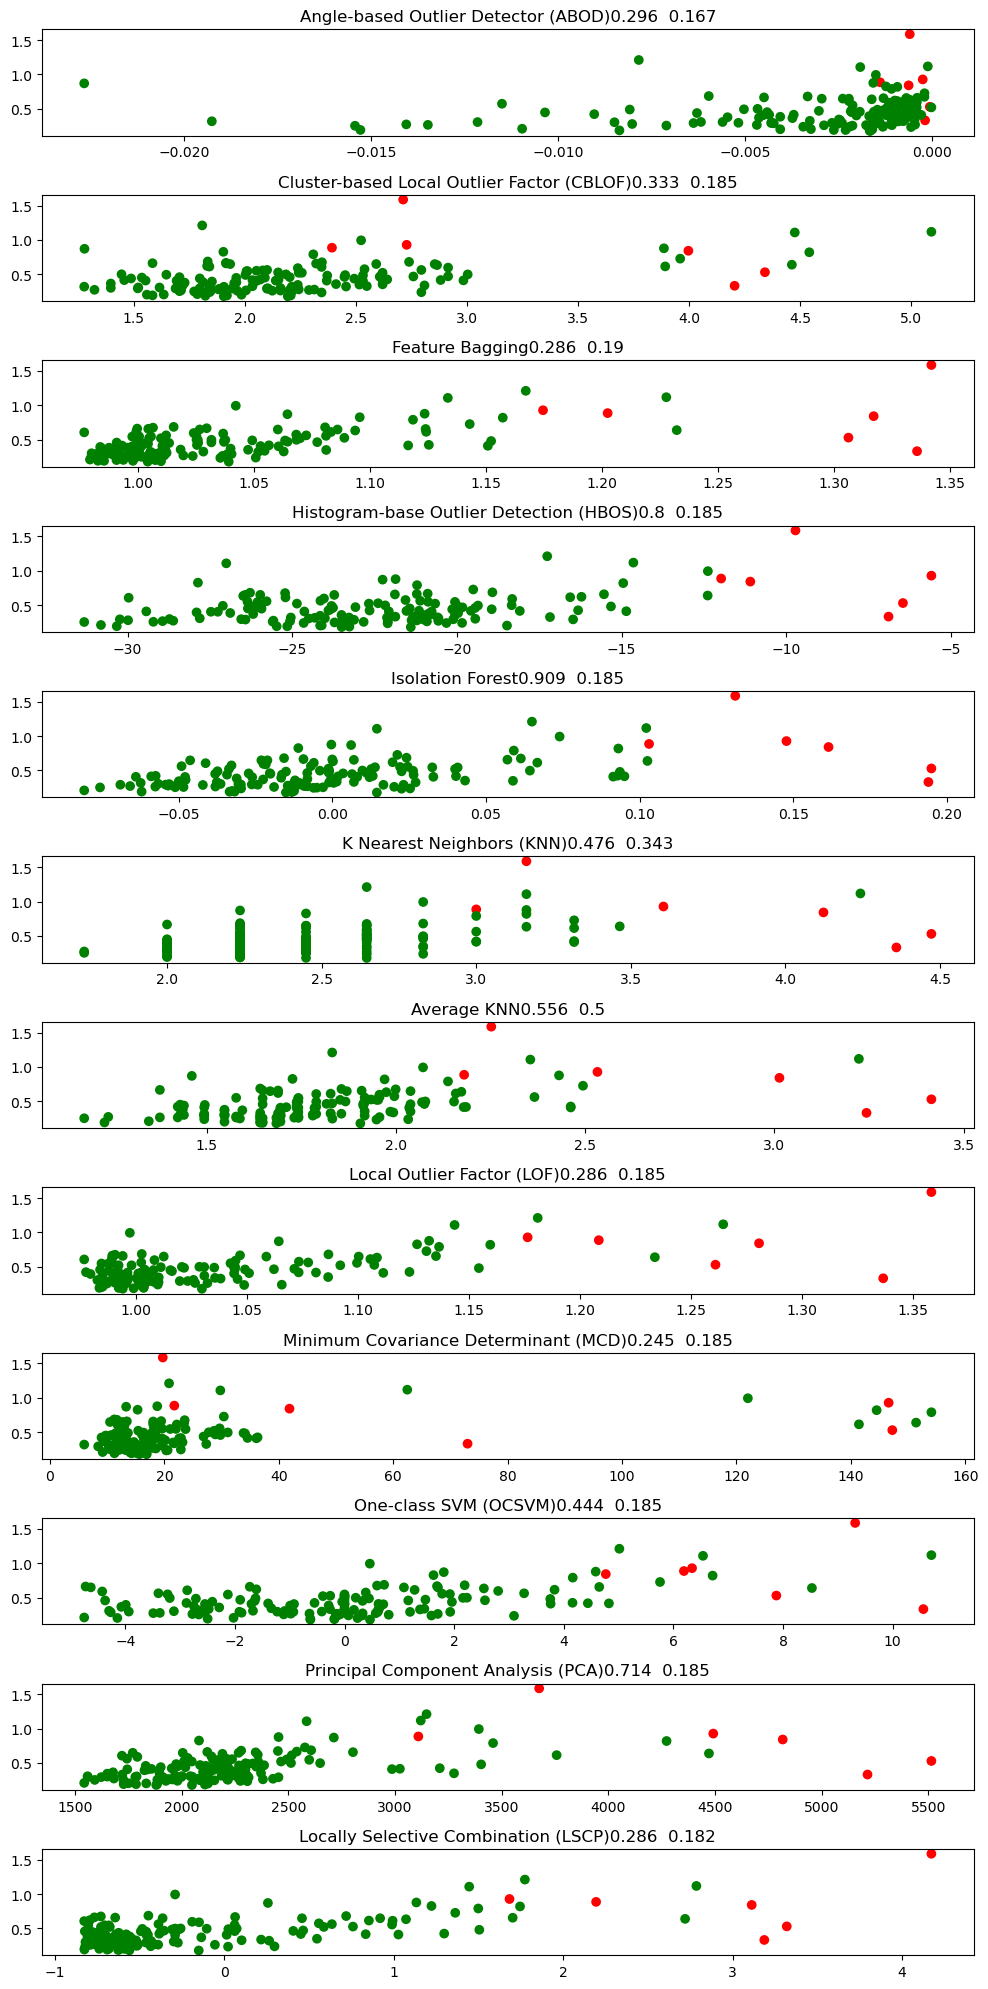

In [50]:
fig, ax = plt.subplots(12, 1, figsize=(10,20))
X, y = getData("lympho.mat")
y_color = ['green' if not i else 'red' for i in y]
for i in range(12):
    ax[i].scatter(result_dict["lympho.mat"][3][:,i], result_dict["lympho.mat"][2], c = y_color)
    ax[i].title.set_text(names[i] + str(round(result_dict["lympho.mat"][0].iloc[4,i],3)) 
                         + "  "+ str(round(result_dict["lympho.mat"][0].iloc[3,i],3)))
plt.tight_layout()
plt.show()

# All other

In [14]:
result_dict.keys()

dict_keys(['pima.mat'])

In [53]:
bug_datasets = ["letter.mat","speech.mat","cardio.mat"]
for datasets in os.listdir("/Users/kadima/experiment_any/anomaly-detection/datasets/"):
    if datasets in bug_datasets:
        continue
    else:
        print(datasets)
        display(result_dict[datasets][0])
        display(pd.DataFrame(np.asarray(result_dict[datasets][1]).reshape(-1,12),
                             columns=result_dict[datasets][0].columns, index = ['sd', 'mad', 'iqr','disagreement'] ))

        print("\n\n")

pima.mat


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,0.000000,0.049645,0.056140,0.095563,0.070175,0.036101,0.043321,0.056140,0.114865,0.000000,0.069204,0.062500
mad,0.000000,0.420650,0.517375,0.517375,0.057143,0.465649,0.472441,0.517375,0.362353,0.000000,0.520737,0.174455
iqr,0.000000,0.108475,0.170732,0.126667,0.070175,0.155340,0.118421,0.171254,0.231638,0.000000,0.127090,0.194529
default,0.481802,0.431304,0.433213,0.528696,0.542609,0.475836,0.379391,0.441652,0.553043,0.420870,0.511304,0.425087
disagreement,0.419552,0.021661,0.014760,0.555804,0.426667,0.308901,0.343434,0.021898,0.399123,0.510304,0.151899,0.014706


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,3.898839e-05,90.983980,1.598976,23.108828,0.120390,57.780390,38.123400,1.612252,61.396758,0.000733,448.700296,2.369168
mad,8.458347e-06,38.436943,0.234055,2.817009,0.130194,21.504689,15.494152,0.240251,20.258582,0.001121,184.899317,1.154838
iqr,1.200092e-05,68.463070,1.288565,22.778228,0.123751,38.740957,28.037795,1.293413,34.894535,0.001047,408.940278,0.995489
disagreement,-5.826450e-07,102.377129,2.559093,19.318974,0.031504,28.451680,19.599315,2.535374,17.484213,-0.000532,379.430807,6.174329





musk.mat


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,0.000000,1.000000,0.021505,0.892473,0.989583,0.013514,0.016667,0.020305,0.594203,0.000000,0.984293,0.030000
mad,0.000000,0.061412,0.061412,0.061412,0.858824,0.061412,0.036550,0.061412,0.128137,0.103761,0.061412,0.027907
iqr,0.000000,0.994872,0.018349,0.905473,0.989583,0.000000,0.017094,0.023077,0.923810,0.081855,0.984456,0.021583
default,0.007491,0.146747,0.031571,0.146747,0.146747,0.042989,0.010101,0.043512,0.146747,0.093868,0.146747,0.051243
disagreement,0.013623,0.715232,0.047926,0.422764,0.152381,0.038068,0.019308,0.052037,0.236364,0.067813,0.422764,0.052143


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,3.334232e-05,1119.377885,1.121675,536.565584,0.060126,617.035420,450.480701,1.116950,68348.673353,0.000687,1.914503e+08,2.355218
mad,7.494205e-12,298.636143,0.098585,3.516014,0.072670,208.251270,163.526302,0.089887,649.643347,0.000246,6.429421e+07,2.274582
iqr,4.419785e-12,974.980907,1.112215,536.156103,0.059771,629.591654,455.538274,1.102385,15868.004014,0.000364,1.902782e+08,1.926406
disagreement,-2.148379e-10,1448.737733,1.005813,538.363984,0.096756,364.067301,219.478364,1.003988,271593.798651,-0.000155,2.339537e+08,-0.648129





thyroid.mat


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,0.000000,0.227488,0.000000,0.497890,0.584746,0.223529,0.218391,0.232804,0.288288,0.137500,0.352273,0.243386
mad,0.000000,0.165907,0.048124,0.021277,0.455556,0.135015,0.145136,0.048124,0.191555,0.161943,0.087038,0.249258
iqr,0.000000,0.308458,0.234234,0.425150,0.459834,0.357309,0.340741,0.244318,0.282575,0.169643,0.362205,0.236559
default,0.000000,0.114856,0.121728,0.114178,0.116105,0.128169,0.181263,0.118029,0.116105,0.106117,0.116105,0.108787
disagreement,0.082192,0.048551,0.000000,0.056655,0.050189,0.049141,0.050379,0.048149,0.049363,0.059255,0.051395,0.055572


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,NaN,0.360713,2.765598e+06,-2.193003,0.170799,0.150542,0.102504,1.659110,16430.453472,60.786809,1240.472687,2.378426
mad,NaN,0.140258,2.475667e-01,7.300475,0.120825,0.046078,0.032952,0.297262,22.496138,40.665942,407.227043,1.299875
iqr,NaN,0.247295,1.359151e+00,-4.531328,0.120101,0.087642,0.061760,1.412395,46.136161,43.769728,816.755390,1.173508
disagreement,-142.479765,0.028398,1.720503e+07,-14.313408,-0.054497,0.008454,0.006759,0.966347,0.644371,-9.133234,269.073502,-0.647094





vowels.mat


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,0.000000,0.172840,0.324324,0.062500,0.171429,0.516129,0.620690,0.381818,0.022727,0.246575,0.063492,0.342857
mad,0.000000,0.131367,0.066401,0.066401,0.075472,0.084746,0.081500,0.066401,0.078704,0.166667,0.067295,0.364780
iqr,0.000000,0.194175,0.323353,0.000000,0.163934,0.571429,0.623656,0.353591,0.024096,0.250000,0.000000,0.358025
default,0.168675,0.151899,0.162602,0.098101,0.129747,0.196850,0.494253,0.163132,0.116904,0.123418,0.082278,0.159744
disagreement,0.069735,0.236311,0.295082,0.000000,0.235294,0.191939,0.101626,0.345455,0.111490,0.236111,0.096386,0.361991


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,3.207885,3.993233,1.326049,22.260395,0.075750,2.319503,1.543594,1.356429,126.136528,61.511949,3490.817192,2.259102
mad,0.419137,2.013922,0.176684,6.138666,0.097122,1.041342,0.676642,0.181062,55.568270,68.029485,1381.639852,1.500127
iqr,0.381311,3.823368,1.239396,23.071796,0.085160,2.226631,1.479408,1.242070,129.851724,63.137615,3592.901838,1.458801
disagreement,-1.803272,2.613405,1.224123,23.113156,0.066507,1.442894,0.778809,1.194687,14.657870,40.118851,3294.069162,0.990803





satellite.mat


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,0.000000,0.315964,0.093416,0.192035,0.165548,0.141641,0.130220,0.097778,0.260426,0.038871,0.214035,0.093458
mad,0.000000,0.569031,0.480699,0.480699,0.465306,0.505898,0.495766,0.480699,0.689950,0.125242,0.459546,0.151211
iqr,0.000000,0.509353,0.133955,0.443024,0.461882,0.207101,0.202521,0.146218,0.595829,0.074894,0.315267,0.149266
default,0.404733,0.550542,0.408820,0.577007,0.573102,0.484753,0.428301,0.403536,0.645987,0.340564,0.460738,0.410834
disagreement,0.479058,0.011719,0.447875,0.005877,0.041287,0.506141,0.493814,0.444042,0.228869,0.300197,0.009775,0.449058


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,2.537253e-07,177.546799,1.465912,115.616407,0.128486,48.189977,35.132628,1.476722,1013.525075,0.000490,542302.681494,2.390874
mad,2.806045e-07,53.940285,0.281903,2.915573,0.091217,19.419862,13.808060,0.278843,65.173840,0.000202,266217.095663,1.828046
iqr,1.749335e-07,93.462252,1.396887,114.346316,0.091994,43.101765,31.558530,1.394121,157.518957,0.000389,487910.528512,1.865094
disagreement,-7.631349e-07,260.531425,1.056347,117.190306,0.155928,19.672316,13.527369,1.052817,1065.656271,0.000083,693846.324896,-0.606457





lympho.mat


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,0.000000,0.428571,0.666667,0.800000,0.909091,0.600000,0.600000,0.666667,0.307692,0.400000,0.666667,0.666667
mad,0.000000,0.078947,0.077922,0.000000,0.909091,0.077922,0.077922,0.077922,0.176471,0.545455,0.077922,0.545455
iqr,0.000000,0.375000,0.750000,0.857143,0.857143,0.500000,0.533333,0.666667,0.444444,0.545455,0.521739,0.705882
default,0.166667,0.184615,0.190476,0.184615,0.184615,0.342857,0.500000,0.184615,0.184615,0.184615,0.184615,0.181818
disagreement,0.296296,0.333333,0.285714,0.800000,0.909091,0.476190,0.555556,0.285714,0.244898,0.444444,0.714286,0.285714


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,0.006399,3.943633,1.217325,-10.533459,0.127423,3.669084,2.696982,1.218080,94.309873,7.909586,3974.617480,2.386309
mad,0.004032,1.317941,0.098544,11.054582,0.109326,0.949257,0.779551,0.086980,17.592915,7.561092,967.079504,1.288751
iqr,0.003421,3.497820,1.155006,-12.414658,0.099212,3.260276,2.429143,1.142611,34.651512,6.747274,3021.188029,1.648615
disagreement,-0.000584,2.713602,1.341911,-9.720204,0.131150,3.162278,2.251504,1.358477,19.720694,9.317072,3675.430273,4.174134





wbc.mat


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,0.000000,0.363636,0.457143,0.611111,0.571429,0.432432,0.388889,0.470588,0.344828,0.413793,0.500000,0.411765
mad,0.000000,0.185841,0.105263,0.173913,0.549020,0.124629,0.132075,0.105263,0.289855,0.491803,0.162791,0.500000
iqr,0.000000,0.538462,0.474576,0.612245,0.560000,0.549020,0.528302,0.491228,0.388889,0.535714,0.560000,0.491228
default,0.222222,0.244186,0.244186,0.244186,0.244186,0.256098,0.391304,0.254545,0.244186,0.232558,0.244186,0.250000
disagreement,0.160000,0.166667,0.357143,0.625000,0.370370,0.086957,0.086957,0.344828,0.437500,0.166667,0.370370,0.357143


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,25.257230,1.028851,1.743521,-5.566513,0.158161,0.791464,0.574255,1.743035,3372.705303,8.687930,3.348517e+06,2.348976
mad,19.775763,0.324828,0.301498,33.355934,0.104072,0.250513,0.188711,0.312490,110.285890,2.633241,1.068384e+06,1.316605
iqr,19.581838,0.698893,1.420133,-17.757732,0.105278,0.620420,0.446922,1.459554,274.674722,2.924901,2.297585e+06,1.304099
disagreement,-0.005739,1.593141,1.949564,-2.805404,0.213541,1.205545,0.924275,1.952617,2147.522116,18.537171,4.471648e+06,3.432943





glass.mat


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,0.000000,0.111111,0.000000,0.000000,0.117647,0.117647,0.117647,0.133333,0.000000,0.105263,0.133333,0.133333
mad,0.000000,0.163934,0.080717,0.000000,0.095238,0.258065,0.222222,0.080717,0.206897,0.148148,0.091743,0.148148
iqr,0.000000,0.125000,0.176471,0.000000,0.111111,0.222222,0.227273,0.181818,0.043478,0.083333,0.111111,0.171429
default,0.193548,0.126316,0.134831,0.084211,0.105263,0.206897,0.235294,0.131868,0.189474,0.105263,0.105263,0.131868
disagreement,0.166667,0.000000,0.190476,0.000000,0.000000,0.000000,0.000000,0.095238,0.000000,0.000000,0.000000,0.181818


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,135.297370,3.867143,2.863907,6.647519,0.196686,3.333042,2.212136,3.093281,7096.979347,33.082490,38543.064092,2.135483
mad,29.490408,1.118825,0.666449,15.007944,0.181935,0.838384,0.430540,0.675138,35.120940,12.414798,13338.190604,0.853100
iqr,34.417478,1.928161,1.809064,7.558638,0.193321,1.584989,0.987213,1.817078,465.034603,29.187690,34198.469233,0.548883
disagreement,-0.000026,5.710356,2.239286,13.588451,0.325810,4.720721,3.617025,2.195146,23331.564377,40.779426,57818.300471,1.266171





satimage-2.mat


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,0.000000,0.788571,0.082090,0.476190,0.566524,0.292035,0.270742,0.079710,0.611354,0.000000,0.730539,0.094203
mad,0.000000,0.082510,0.024174,0.024174,0.435065,0.031640,0.027434,0.024174,0.077469,0.000000,0.051207,0.072893
iqr,0.000000,0.474227,0.063570,0.299020,0.393162,0.203297,0.185792,0.061758,0.194254,0.000000,0.721893,0.072562
default,0.041651,0.059365,0.020743,0.058528,0.059365,0.063120,0.111226,0.021432,0.059365,0.020067,0.058528,0.022613
disagreement,0.027473,0.106667,0.019218,0.131579,0.106667,0.132571,0.100000,0.019286,0.537815,0.024412,0.106667,0.020121


,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor (LOF),Minimum Covariance Determinant (MCD),One-class SVM (OCSVM),Principal Component Analysis (PCA),Locally Selective Combination (LSCP)
sd,2.482073e-07,98.538230,1.478660,114.278031,0.106369,46.146462,33.522359,1.485320,483.760448,0.000500,398083.189650,2.389463
mad,2.813051e-07,44.497736,0.268230,2.910328,0.085825,18.662439,13.187549,0.268408,54.626094,0.000448,213127.484306,1.703941
iqr,1.756973e-07,78.856353,1.380911,113.270786,0.078001,40.879043,29.914119,1.379072,111.661405,0.000523,396587.318374,1.698618
disagreement,-2.852742e-07,248.716685,1.055732,118.584998,0.275146,32.124757,21.986723,1.054562,1064.989967,-0.000455,665148.524197,-0.513985
